# Импорт библиотек и настройка конфигурации

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from tqdm import tqdm
import progressbar
import datetime
import pickle

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import spacy
import wordninja
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


plt.style.use("seaborn-darkgrid")
plt.rc("font", size=20)

In [2]:
torch.__version__

'1.11.0+cu113'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
spacy.__version__

'3.7.4'

In [5]:
spacy.require_gpu()

True

In [6]:
pd.__version__

'1.4.1'

In [7]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

```
pip install -U pip setuptools wheel cupy progressbar wordninja
pip install -U 'spacy[cuda11x,transformers,lookups]'
python -m spacy download en_core_web_sm
python -m spacy download ru_core_news_sm
```

# Данные

https://www.kaggle.com/datasets/phantomrider/twitter-emotion  
Задача: классификация.  
Нужно определить эмоцию по тексту публикации.

In [8]:
df = pd.read_csv("twitter emotions.csv")

In [9]:
df.head()

,id,text,emotion,intensity
0,10857,@ZubairSabirPTI pls dont insult the word 'Molna',anger,0.479
1,10858,@ArcticFantasy I would have almost took offens...,anger,0.458
2,10859,@IllinoisLoyalty that Rutgers game was an abom...,anger,0.562
3,10860,@CozanGaming that's what lisa asked before she...,anger,0.5
4,10861,Sometimes I get mad over something so minuscul...,anger,0.708


In [10]:
df.head()["text"].iloc[1]

'@ArcticFantasy I would have almost took offense to this if I actually snapped you'

In [11]:
df.tail()

,id,text,emotion,intensity
10586,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104
10587,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104
10588,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088
10589,40784,@BluesfestByron second artist announcement loo...,sadness,0.083
10590,40785,I can literally eat creamy pesto pasta topped ...,sadness,0.083


In [12]:
df.tail()["text"].iloc[-5]

"@VivienLloyd Thank you so much! Just home - stunned but so happy. Don't think it has sunk in yet! Wow."

# Предобработка данных и смена задачи

Так как этот датасет рассчитан на определение не только эмоций, но и их вероятностей, а обучающие данные есть только по одной эмоциии для каждого текста, упрощу задачу, заменив эмоции на противоположные для вероятностей меньше 0.5.

In [13]:
df.emotion.unique().tolist()

['anger', 'joy', 'fear', 'sadness']

У текстов возможны следующие метки эмоций:
- "anger" злость
- "joy": радость
- "fear": страх
- "sadness": грусть.

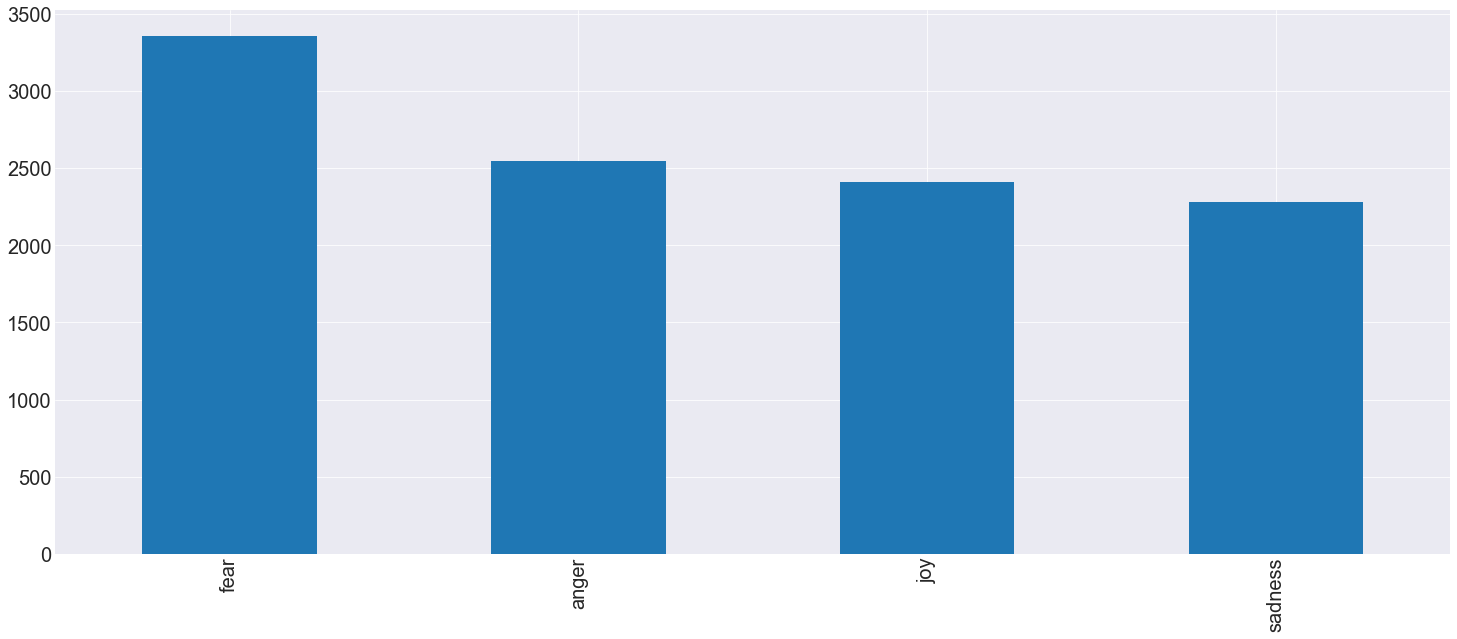

In [14]:
plt.figure(figsize=(25, 10))
plt.rc("font", size=20)

df["emotion"].value_counts().plot(kind="bar")
None

Баланс классов есть, с небольшим преобладанием эмоции страха.

In [15]:
df.dtypes

id            int64
text         object
emotion      object
intensity    object
dtype: object

In [16]:
df.shape

(10591, 4)

In [17]:
df.id.nunique()

7102

In [18]:
df[df["intensity"]=="NONE"].iloc[5]["text"]

'Sometimes I get mad over something so minuscule I try to ruin somebodies life not like lose your job like get you into federal prison #anger'

In [19]:
df[df["text"]=="Sometimes I get mad over something so minuscule I try to ruin somebodies life not like lose your job like get you into federal prison #anger"]

,id,text,emotion,intensity
5,10862,Sometimes I get mad over something so minuscul...,anger,0.646
89,10862,Sometimes I get mad over something so minuscul...,anger,NONE


In [20]:
df[df["intensity"]=="NONE"].shape[0]

3489

In [21]:
7102 + 3489, 10591

(10591, 10591)

Часть строк по какой-то причине повторяется, причём во втором экземпляре всегда стоит значение "NONE".  
Удалю дубликаты перед дальнейшим анализом.

In [22]:
df = df[df["intensity"]!="NONE"]

In [23]:
df.shape

(7102, 4)

In [24]:
df.isna().sum()

id           0
text         0
emotion      0
intensity    0
dtype: int64

In [25]:
df["intensity"] = df["intensity"].astype("float")

Полностью объективно произвести замену не получится, так как здесь сложно выделить явные противоположности.
Нужно подобрать вариант с наименьшим дисбалансом меток.

In [26]:
opposite_emotions = {
    "anger": "joy",
    "joy": "anger",
    "fear": "anger",
    "sadness": "joy"
}

In [27]:
def replace_emotion(emotion, intensity):
    if intensity < 0.3:
        emotion = opposite_emotions[emotion]

    return emotion

In [28]:
df["emotion"] = df[["emotion", "intensity"]].apply(lambda x: replace_emotion(x.emotion, x.intensity), axis=1)
df = df.iloc[:, :3]

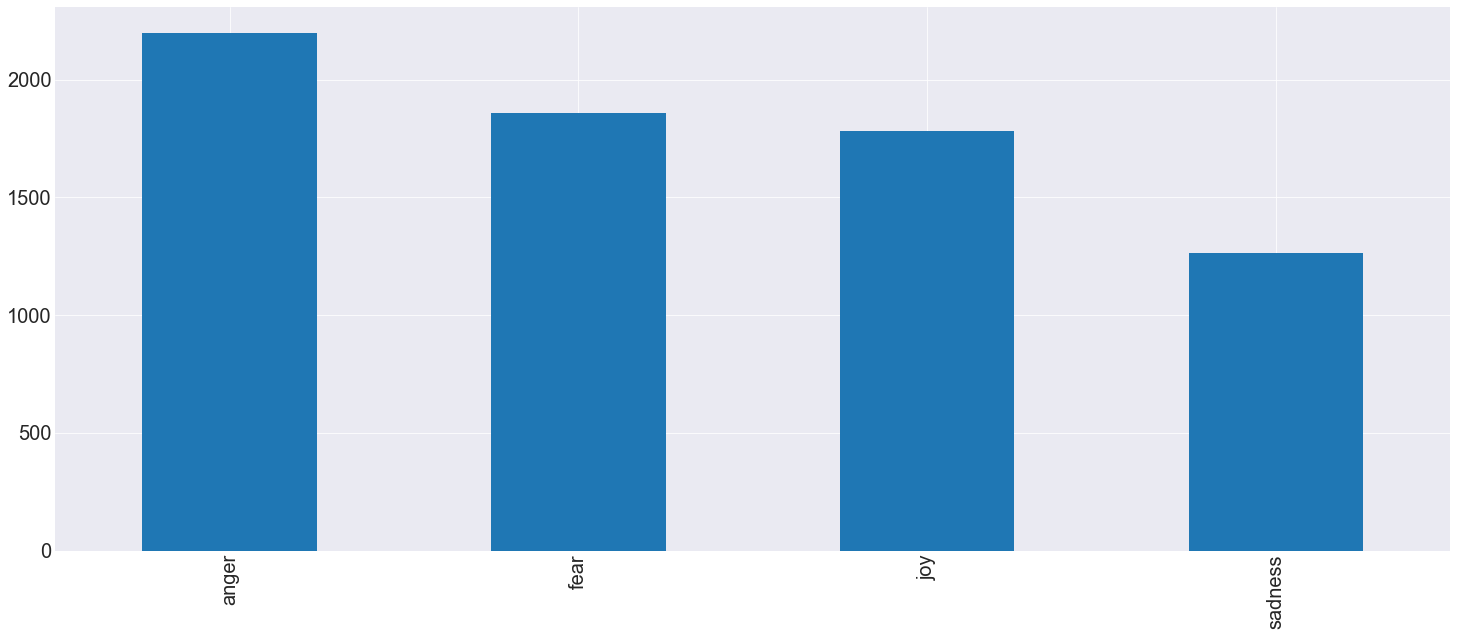

In [29]:
plt.figure(figsize=(25, 10))
plt.rc("font", size=20)

df["emotion"].value_counts().plot(kind="bar")
None

Распределение значительно изменилось. Теперь преобладает эмоция агрессии, а отстаёт по количеству строк грусть.

In [30]:
df.tail()

,id,text,emotion
10586,40781,@VivienLloyd Thank you so much! Just home - st...,joy
10587,40782,Just put the winter duvet on ☃️❄️🌬☔️,joy
10588,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,joy
10589,40784,@BluesfestByron second artist announcement loo...,joy
10590,40785,I can literally eat creamy pesto pasta topped ...,joy


In [31]:
df.tail()["text"].iloc[-5]

"@VivienLloyd Thank you so much! Just home - stunned but so happy. Don't think it has sunk in yet! Wow."

<!-- Так как данные слишком объёмные, сохраню для дальнейшего анализа лишь их часть: -->

# Разделение данных

In [32]:
df_full_train, df_test = train_test_split(df, stratify=df["emotion"], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=2)
df_full_train.reset_index(inplace=True)
df_test.reset_index(inplace=True, drop=True)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

Проверка соотношения 20 | 20 | 60:

In [33]:
df_test.shape[0] / (df_full_train.shape[0] + df_test.shape[0]),\
df_val.shape[0] / (df_train.shape[0] + df_val.shape[0] + df_test.shape[0]),\
df_train.shape[0] / (df_train.shape[0] + df_val.shape[0] + df_test.shape[0])

(0.20008448324415656, 0.20008448324415656, 0.5998310335116869)

___

In [34]:
df_train.shape

(4260, 3)

# Обработка данных и нормализация

In [35]:
def get_random_texts(data, n, random_state=1):
    for t in data.sample(n, random_state=random_state).text.tolist():
        print(t)

In [36]:
get_random_texts(df_train, 5)

I might not pay for my own health insurance but I do like sparkling water and Brussels sprouts now so I think I'm an adult
@voguemagazine, did you not learn from @FreePeople 's viral insult to ballet? Stop trying to wrongfully stick models into pointe shoes 🙄
#GoodAfternoon! ^^ Doesn't matter whn you #start something, as long as you start it #today. 'Age' only exists in the mind. You are #Timeless
@ETimsNet I wanted him dropped a while ago. Its a concern for us no doubt
Candice's pout gets more preposterous by the week. This week it's gone a bit Jack Nicholson's Joker. #GBBO


Как видно из случайных примеров, тексты достаточно уникальные, в них встречается много сленга, сокращений и тегов.  
Требуется тщательная обработка.

In [37]:
df.head()

,id,text,emotion
0,10857,@ZubairSabirPTI pls dont insult the word 'Molna',anger
1,10858,@ArcticFantasy I would have almost took offens...,anger
2,10859,@IllinoisLoyalty that Rutgers game was an abom...,anger
3,10860,@CozanGaming that's what lisa asked before she...,anger
4,10861,Sometimes I get mad over something so minuscul...,anger


In [38]:
def show_statistics(df):
    texts = df["text"]
    lengths = [len(sent.split()) for sent in texts]

    mean = np.mean(lengths)
    std = np.std(lengths)
    words = [word for sent in texts for word in sent.split()]
    word_counts = Counter(words)

    print(f"Количество предложений: {len(df)}")
    print(f"Среднее значение: {mean:.2f}")
    print(f"Стандартное отклонение: {std:.2f}")
    print(f"Количество уникальных слов: {len(word_counts)}")

    plt.figure(figsize=(25, 10))
    plt.rc("font", size=20)
    plt.subplot(2, 2, 1)
    plt.hist(lengths, bins=30, color='blue', alpha=0.7, log=True)
    plt.title("Гистограмма распределения длин предложений")
    plt.xlabel("Количество слов")
    plt.ylabel("Частота")

    plt.subplot(2, 2, 2)
    plt.hist(word_counts.values(), bins=30, color='red', alpha=0.7, log=True)
    plt.title("Гистограмма частотности слов")
    plt.xlabel("Частота")
    plt.ylabel("Количество слов")

Количество предложений: 4260
Среднее значение: 16.12
Стандартное отклонение: 6.61
Количество уникальных слов: 18001


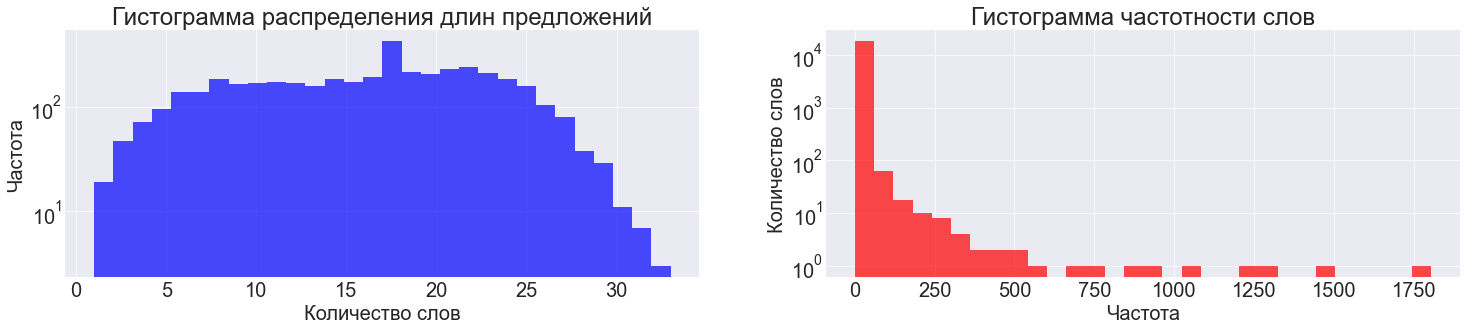

In [39]:
show_statistics(df_train)

Длины предложений имеют хорошее распределение в виде плато, но, как уже говорилось ранее, имеется много уникальных слов.

In [40]:
nlp_en = spacy.load("en_core_web_sm")


def normalize(df):
    output_data = []
    tqdm.pandas()
    
    for row in tqdm(df.iterrows(), total=len(df)):
        series = {}
        series["text"] = norm_text(row[1]["text"])
        series["emotion"] = row[1]["emotion"]
        output_data.append(series)
    
    return pd.DataFrame(output_data)


def norm_text(text):
    return (' '.join(token.lemma_.lower() for token in nlp_en(text)))

In [180]:
normalized_df_train = normalize(df_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4260/4260 [01:56<00:00, 36.54it/s]


In [41]:
def save_data(data, name: str):
    with open(f"Cached_data/{name}", "wb") as file:
        pickle.dump(data, file)


def load_data(name: str) -> tuple:
    with open(f"Cached_data/{name}", "rb") as file:
        data = pickle.load(file)

    return data

In [42]:
NORM_DATA_NAME = "normalized_df_train.pkl"

In [183]:
save_data(normalized_df_train, NORM_DATA_NAME)

In [43]:
normalized_df_train = load_data(NORM_DATA_NAME)

i might not pay for my own health insurance but i do like sparkle water and brussels sprout now so i think i be an adult
@voguemagazine , do you not learn from @freepeople 's viral insult to ballet ? stop try to wrongfully stick model into pointe shoe 🙄
# goodafternoon ! ^^ do not matter whn you # start something , as long as you start it # today . ' age ' only exist in the mind . you be # timeless
@etimsnet i want he drop a while ago . its a concern for we no doubt
candice 's pout get more preposterous by the week . this week it be go a bit jack nicholson 's joker . # gbbo
Количество предложений: 4260
Среднее значение: 19.74
Стандартное отклонение: 8.09
Количество уникальных слов: 11365


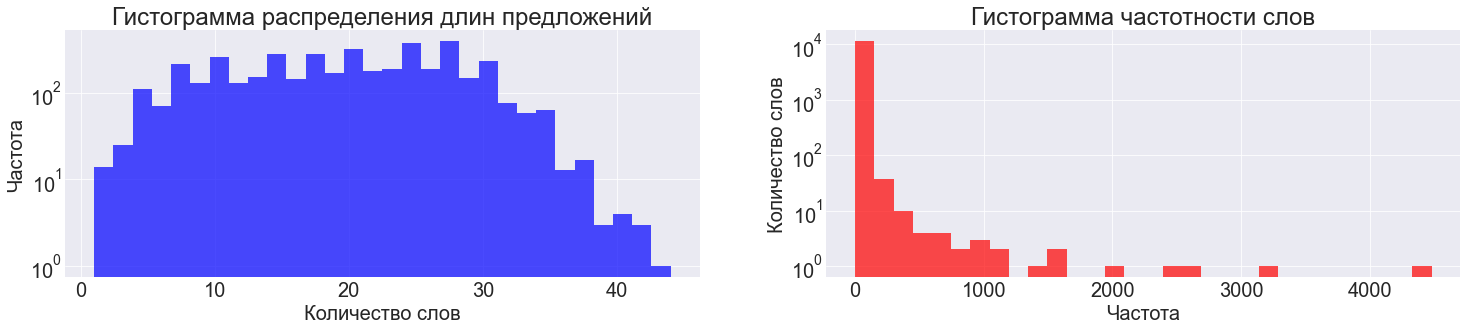

In [44]:
get_random_texts(normalized_df_train, 5)
show_statistics(normalized_df_train)

Слов стало меньше, но статистика пострадала. Стоит попробовать нормализовать длину предложений.

Также требуется дополнительная обработка текста.  
Сейчас видно несколько проблем ввиду особенностей источника данных. Так как тексты взяты из социальной сети, встречаются следующие нюансы:  
- **Теги пользователей.**  
  &nbsp;&nbsp;Их можно заменить на универсальный код, например, \<addressing\>
- **Хэштеги.**  
  &nbsp;&nbsp;Среди них встречаются как обычные слова, так и их комбинации без пробелов или просто набор букв.  
  &nbsp;&nbsp;Для разделения слитных слов нужен семантический анализ, а комбинации букв не поддаются простому анализу.
- **Сленг.**  
  &nbsp;&nbsp;Здесь понадобится семантический анализ для замены на нормативную лексику из словаря.
- **Символы переноса строки \n.**  
  &nbsp;&nbsp;Их нужно просто убрать разделением.

С помощью специальной библиотеки wordninja можно разбить слитные слова на составляющие, а небольшим ветвлением проверить на наличие тега.  
Новая функция нормализации:

In [45]:
def norm_text(text):
    tokens = []
    prev_token = ""

    for token in nlp_en(text):
        token_normal = " ".join(
            token.lemma_\
                 .lower()\
                 .split("\\n")
        )

        if ~is_word_in_corpus(token_normal) and prev_token == "#":
            tokens.extend(wordninja.split(token_normal))
        else:
            if token_normal[0] == "@":
                tokens.append("<addressing>")
            else:
                tokens.append(token_normal)

        prev_token = token_normal
    
    return (' '.join(tokens).strip())


def is_word_in_corpus(word):
    return nlp_en.vocab[word].is_oov == False

In [46]:
print("Оригинальные данные:")

for t in (df_train.head()["text"]):
    print(t)

Оригинальные данные:
A3: But chronic sadness may mean there are underlying issues than getting sad occassionally over a particular issue (2/2) #mhchat
@m_warner21 Yikes. The wrath of Maddie...
Knowing I have my hair to wash and dry is like knowing you had that English close reading in your school bag to do #dread
a good shorty has so much to offer &amp; it's sad that some of you niggas don't even see it when she right in front of your face and too late
@RadiateZen That's true, it does go both ways. But I've been on the receiving end of a vegans wrath! Lol! I personally wouldn't condemn


In [47]:
print("Обработанные данные:")

for t in (normalize(df_train.head())["text"]):
    print(t)

Обработанные данные:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]

a3 : but chronic sadness may mean there be underlie issue than get sad occassionally over a particular issue ( 2/2 ) # mh chat
<addressing> yikes . the wrath of maddie ...
know i have my hair to wash and dry be like know you have that english close reading in your school bag to do # dread
a good shorty have so much to offer & amp ; it be sad that some of you niggas do not even see it when she right in front of your face and too late
<addressing> that be true , it do go both way . but i have be on the receiving end of a vegan wrath ! lol ! i personally would not condemn


Достаточно хороший результат.

In [ ]:
normalized_df_train = normalize(df_train)
get_random_texts(normalized_df_train, 5)
show_statistics(normalized_df_train)

In [49]:
NORM_DATA_NAME = "normalized_df_train_v2.pkl"

In [190]:
save_data(normalized_df_train, NORM_DATA_NAME)

In [50]:
normalized_df_train = load_data(NORM_DATA_NAME)

i might not pay for my own health insurance but i do like sparkle water and brussels sprout now so i think i be an adult
@voguemagazine , do you not learn from @freepeople 's viral insult to ballet ? stop try to wrongfully stick model into pointe shoe 🙄
# goodafternoon ! ^^ do not matter whn you # start something , as long as you start it # today . ' age ' only exist in the mind . you be # timeless
@etimsnet i want he drop a while ago . its a concern for we no doubt
candice 's pout get more preposterous by the week . this week it be go a bit jack nicholson 's joker . # gbbo
Количество предложений: 4260
Среднее значение: 19.74
Стандартное отклонение: 8.09
Количество уникальных слов: 11365


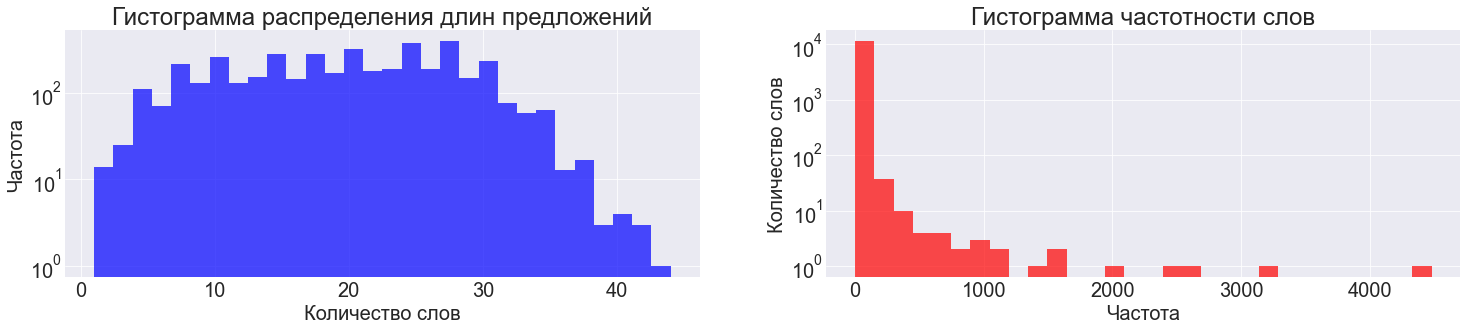

In [51]:
get_random_texts(normalized_df_train, 5)
show_statistics(normalized_df_train)

Нормализация длины предложений:

In [52]:
def filter_sentence_lengths(df, shortest_percent, longest_percent):
    df_sorted = df.sort_values(by="text", key=lambda x: x.str.split().str.len())
    length = df.shape[0]
    return df_sorted[int(length * shortest_percent):length - int(length * longest_percent)]

Путём перебора комбинаций среза предложений было найдено оптимальное соотношение:

@cbcnews canada should be a drive force of democracy freedom right - instead we help # dictator # misogyny # sharia # islam   # polygamy
happiness be ... not have to set the alarm clock for the next day
like srsly somebody help i deal with this social anxiety
brb , go 2 start kill random white people go about their normal day . do not worry though i be white , so they will safely apprehend i
another rage storm bring on by my own emotion sorry everyone . enjoy the thunder
Количество предложений: 3408
Среднее значение: 19.87
Стандартное отклонение: 6.09
Количество уникальных слов: 10076


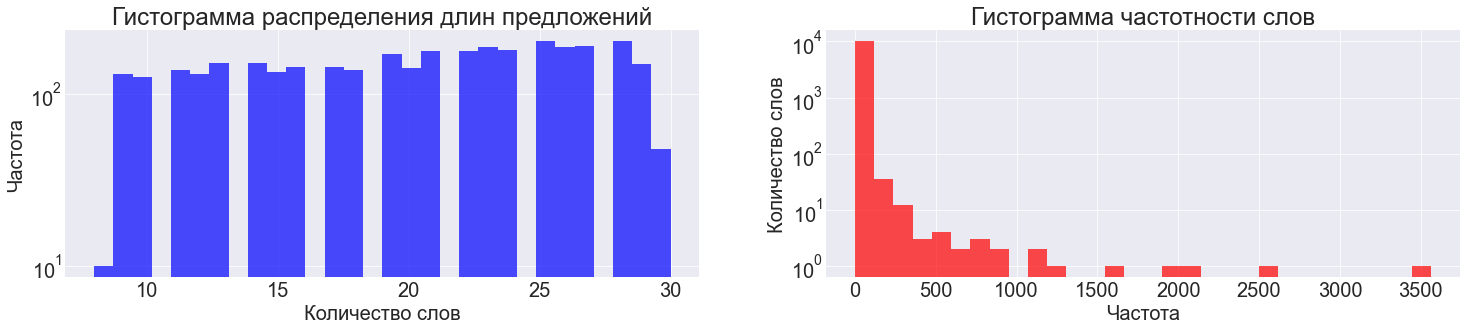

In [53]:
norm_filt_df_train = filter_sentence_lengths(normalized_df_train, 0.1, 0.1)
get_random_texts(norm_filt_df_train, 5, 2)
show_statistics(norm_filt_df_train)

Стандартное отклонение уменьшилось, как и количество уникальных слов.  
Нужно будет обучить модель на обоих датасетах.

# Создание словаря и подготовка загрузчика данных

In [54]:
class Vocabulary:
    spec_tokens = {
        "<pad>": 0,
        "<unk>": 1
    }

    def __init__(self, sentences, max_size):
        self.index_to_token = {}
        self.token_to_index = {}

        for token, index in self.spec_tokens.items():
            self.token_to_index[token] = index
            self.index_to_token[index] = token

        word_freq = Counter(word for sent in sentences for word in sent.split())
        most_common_words = word_freq.most_common(max_size - len(self.spec_tokens))

        for word, _ in most_common_words:
            index = len(self.token_to_index)
            self.token_to_index[word] = index
            self.index_to_token[index] = word

    def tokenize(self, sent):
        return [self.token_to_index.get(token, self.spec_tokens["<unk>"]) for token in sent.split()]

    def __len__(self):
        return len(self.token_to_index)

In [55]:
train_sentences = norm_filt_df_train["text"].values

VOCAB_SIZE = 7750
vocab = Vocabulary(train_sentences, VOCAB_SIZE)

In [56]:
list(vocab.index_to_token.items())[:10]

[(0, '<pad>'),
 (1, '<unk>'),
 (2, '#'),
 (3, 'be'),
 (4, '.'),
 (5, 'i'),
 (6, 'the'),
 (7, 'to'),
 (8, ','),
 (9, 'a')]

In [57]:
len(vocab)

7750

In [58]:
class EmotionDataset(Dataset):
    def __init__(self, x_tensors, y_tensors):
        self.data = x_tensors
        self.label = y_tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.label.size() == 0:
            return self.data[idx]
        else:
            return self.data[idx], self.label[idx]


def collate(batch):
    texts = [example[0] for example in batch]
    labels = [example[1] for example in batch]
    data_padded = pad_sequence(texts, batch_first=True, padding_value=vocab.spec_tokens["<pad>"])
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return data_padded, labels_tensor


BATCH_SIZE = 128

train_tensors = [torch.tensor(vocab.tokenize(sent), dtype=torch.long) for sent in train_sentences]
encoder = LabelEncoder()
y_train = encoder.fit_transform(norm_filt_df_train["emotion"].values)
train_emotions = torch.LongTensor(y_train)
train_dataset = EmotionDataset(train_tensors, train_emotions)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)

normalized_df_val = normalize(df_val)
val_sentences = normalized_df_val["text"].values
val_tensors = [torch.tensor(vocab.tokenize(sent), dtype=torch.long) for sent in val_sentences]
y_val = encoder.fit_transform(normalized_df_val["emotion"].values)
val_emotions = torch.LongTensor(y_val)
val_dataset = EmotionDataset(val_tensors, val_emotions)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1421/1421 [01:36<00:00, 14.73it/s]


___

# Обучение нейронной сети

Напишу простую нейросеть на основе эмбеддинга и линейного слоя:

In [119]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.linear = nn.Linear(embedding_size, num_classes)
    
    def forward(self, X_batch):
        X = self.embedding(X_batch)
        X = torch.mean(X, dim=1)
        X = self.linear(X)
        return X

num_embeddings (int): size of the dictionary of embeddings  
embedding_dim (int): the size of each embedding vector  
Количество эмбеддингов, равное размеру словаря.  
Рамзер каждого эмбеддинга, равный размеру батча

In [120]:
n_classes = df_train.emotion.nunique()
n_classes

4

In [121]:
VOCAB_SIZE

7750

In [122]:
EMBEDDING_SIZE = 128

In [123]:
text_classifier = TextClassifier(VOCAB_SIZE, EMBEDDING_SIZE, n_classes)

for X, y in train_loader:
    y_preds = text_classifier(X)
    print(y_preds.shape)
    break

torch.Size([128, 4])


In [124]:
class Trainer:
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters())
        self.criterion = nn.CrossEntropyLoss()
    
    def train(self, data, epochs):
        losses = {}
        
        for epoch in range(epochs):
            for texts, labels in data:
                texts, labels = texts.to(self.device), labels.to(self.device)
                outputs = self.model(texts)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            loss = loss.item()
            losses[epoch] = loss
            print(f'Эпоха {epoch}, Потери: {loss}')

        return losses

In [126]:
trainer = Trainer(text_classifier, device)
losses = trainer.train(train_loader, epochs=50)

Эпоха 0, Потери: 1.2782552242279053
Эпоха 1, Потери: 1.3012055158615112
Эпоха 2, Потери: 1.1717299222946167
Эпоха 3, Потери: 1.202954888343811
Эпоха 4, Потери: 1.2441176176071167
Эпоха 5, Потери: 1.202984094619751
Эпоха 6, Потери: 1.046081304550171
Эпоха 7, Потери: 1.0607283115386963
Эпоха 8, Потери: 0.9485896825790405
Эпоха 9, Потери: 0.9667054414749146
Эпоха 10, Потери: 0.9222682118415833
Эпоха 11, Потери: 0.8895109295845032
Эпоха 12, Потери: 0.938778281211853
Эпоха 13, Потери: 0.7755869626998901
Эпоха 14, Потери: 0.8031216859817505
Эпоха 15, Потери: 0.739970326423645
Эпоха 16, Потери: 0.7843223214149475
Эпоха 17, Потери: 0.7245646119117737
Эпоха 18, Потери: 0.6095896363258362
Эпоха 19, Потери: 0.5757684111595154
Эпоха 20, Потери: 0.49790844321250916
Эпоха 21, Потери: 0.5241241455078125
Эпоха 22, Потери: 0.5612481236457825
Эпоха 23, Потери: 0.43267783522605896
Эпоха 24, Потери: 0.3770320415496826
Эпоха 25, Потери: 0.4434082508087158
Эпоха 26, Потери: 0.40420064330101013
Эпоха 27, Пот

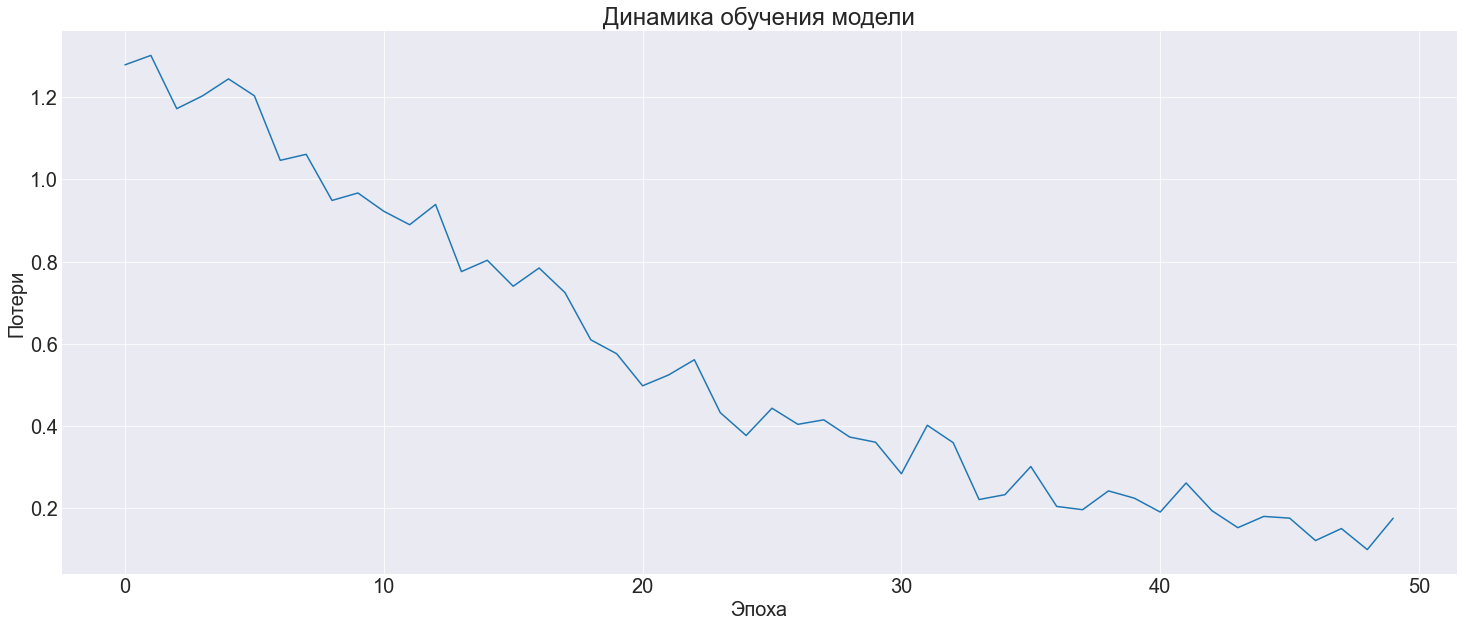

In [127]:
plt.figure(figsize=(25, 10))
plt.rc("font", size=20)

losses_df = pd.DataFrame(losses.items())
plt.plot(losses_df.iloc[:,0], losses_df.iloc[:,1])
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Динамика обучения модели")
None

Обучение происходит адекватно, после сотой эпохи модель перестала снижать потери и приблизилась к нулю.  
Теперь нужно проверить точность на валидационной выборке.  
Обновлённый тренировочный класс:

In [128]:
class Trainer(Trainer):
    def evaluate(self, data):
        self.model.eval()
        losses = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for texts, labels in data:
                texts, labels = texts.to(self.device), labels.to(self.device)
                outputs = self.model(texts)
                loss = self.criterion(outputs, labels)
                losses += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Потери: {losses / len(data)}, Точность: {accuracy}')
    
        return losses / len(data), accuracy

In [129]:
trainer = Trainer(text_classifier, device)
trainer.train(train_loader, epochs=50)
trainer.evaluate(val_loader)

Эпоха 0, Потери: 0.12023105472326279
Эпоха 1, Потери: 0.14702071249485016
Эпоха 2, Потери: 0.12116479873657227
Эпоха 3, Потери: 0.1002654880285263
Эпоха 4, Потери: 0.1216864213347435
Эпоха 5, Потери: 0.17032462358474731
Эпоха 6, Потери: 0.10868716239929199
Эпоха 7, Потери: 0.05184341222047806
Эпоха 8, Потери: 0.09992307424545288
Эпоха 9, Потери: 0.11376316845417023
Эпоха 10, Потери: 0.12014420330524445
Эпоха 11, Потери: 0.0854417234659195
Эпоха 12, Потери: 0.14941288530826569
Эпоха 13, Потери: 0.07898203283548355
Эпоха 14, Потери: 0.10233727842569351
Эпоха 15, Потери: 0.07517662644386292
Эпоха 16, Потери: 0.060830771923065186
Эпоха 17, Потери: 0.060675568878650665
Эпоха 18, Потери: 0.09374396502971649
Эпоха 19, Потери: 0.07687658071517944
Эпоха 20, Потери: 0.07819680869579315
Эпоха 21, Потери: 0.08708006143569946
Эпоха 22, Потери: 0.04924926534295082
Эпоха 23, Потери: 0.04179145768284798
Эпоха 24, Потери: 0.06948243081569672
Эпоха 25, Потери: 0.07653459906578064
Эпоха 26, Потери: 0.049

(0.9659264882405599, 0.6720619282195637)

Добавлю вывод потерь на валидационной выборке, чтобы смотреть на динамику на каждой эпохе:

In [130]:
class Trainer(Trainer):
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
    
    def train(self, train_data, val_data, n_epochs):
        epochs = []
        train_losses = []
        val_losses = []

        for epoch in range(n_epochs):
            self.model.train()
            epochs.append(epoch)
            cur_train_loss = 0

            for texts, labels in train_data:
                texts, labels = texts.to(self.device), labels.to(self.device)
                outputs = self.model(texts)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                cur_train_loss += loss.item()

            epoch_train_loss = cur_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)

            self.model.eval()
            cur_val_loss = 0

            with torch.no_grad():
                for texts, labels in val_data:
                    texts, labels = texts.to(self.device), labels.to(self.device)
                    outputs = self.model(texts)
                    loss = self.criterion(outputs, labels)
                    cur_val_loss += loss.item()

            epoch_val_loss = cur_val_loss / len(val_data)
            val_losses.append(epoch_val_loss)
            print(f'Эпоха {epoch}, Тренировочные потери: {epoch_train_loss:,.3f}, Валидационные потери: {epoch_val_loss:,.3f}')

        return (epochs, train_losses, val_losses)

In [131]:
text_classifier = TextClassifier(VOCAB_SIZE, EMBEDDING_SIZE, n_classes)
trainer = Trainer(text_classifier, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=50)

Эпоха 0, Тренировочные потери: 1.376, Валидационные потери: 1.365
Эпоха 1, Тренировочные потери: 1.351, Валидационные потери: 1.356
Эпоха 2, Тренировочные потери: 1.332, Валидационные потери: 1.348
Эпоха 3, Тренировочные потери: 1.315, Валидационные потери: 1.340
Эпоха 4, Тренировочные потери: 1.296, Валидационные потери: 1.333
Эпоха 5, Тренировочные потери: 1.274, Валидационные потери: 1.324
Эпоха 6, Тренировочные потери: 1.248, Валидационные потери: 1.313
Эпоха 7, Тренировочные потери: 1.219, Валидационные потери: 1.301
Эпоха 8, Тренировочные потери: 1.187, Валидационные потери: 1.289
Эпоха 9, Тренировочные потери: 1.151, Валидационные потери: 1.275
Эпоха 10, Тренировочные потери: 1.113, Валидационные потери: 1.258
Эпоха 11, Тренировочные потери: 1.070, Валидационные потери: 1.241
Эпоха 12, Тренировочные потери: 1.027, Валидационные потери: 1.224
Эпоха 13, Тренировочные потери: 0.980, Валидационные потери: 1.205
Эпоха 14, Тренировочные потери: 0.932, Валидационные потери: 1.187
Эпоха

In [132]:
def draw_training_log(epochs, train_losses, val_losses):
    plt.figure(figsize=(25, 10))
    plt.rc("font", size=20)
    plt.plot(epochs, train_losses, label="Потери обучающей выборки")
    plt.plot(epochs, val_losses, label="Потери валидационной выборки")
    plt.xlabel("Эпоха")
    plt.ylabel("Потери")
    plt.title("Динамика обучения модели")
    plt.legend()

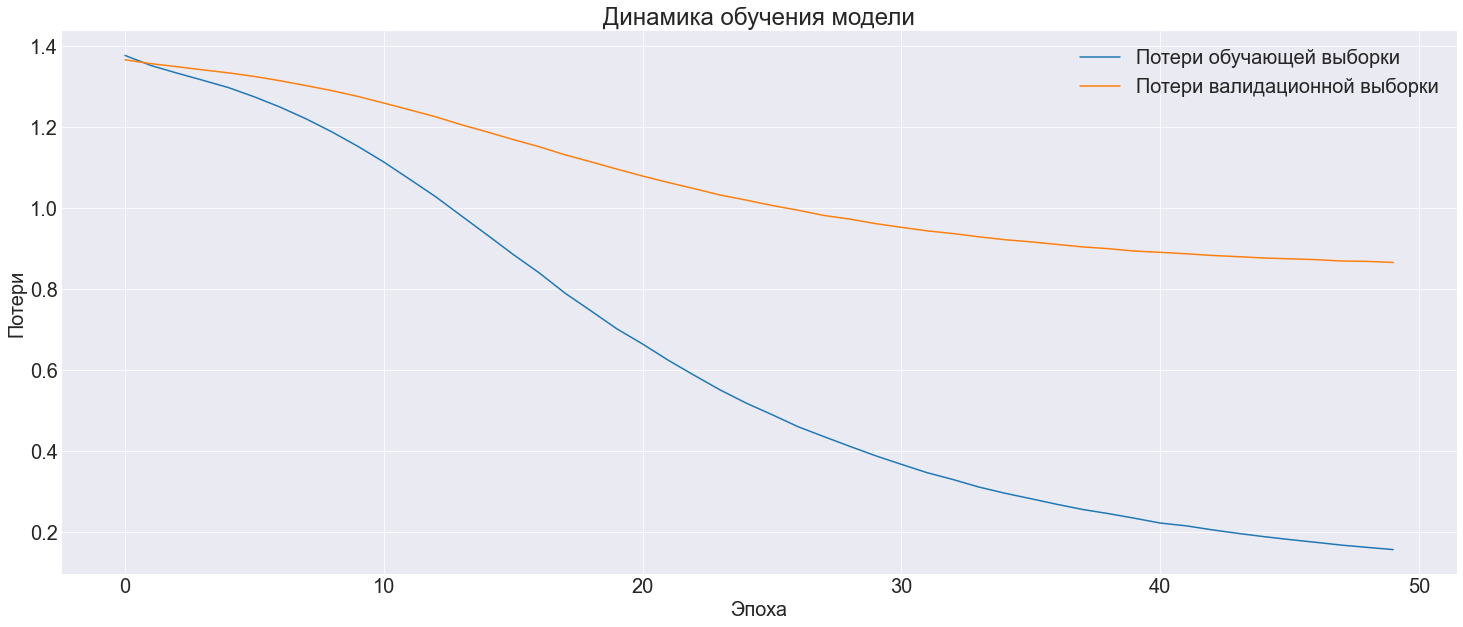

In [133]:
draw_training_log(epochs, train_losses, val_losses)

В определённый момент, в окрестности 40-ой эпохи, обучение перестаёт быть эффективным.  
Потери на валидационной выборке даже начинают немного расти.  
Попробую добавить слой Pool1d:

In [134]:
class TextClassifier_v2(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_classes):
        super(TextClassifier_v2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.linear = nn.Linear(embedding_size, num_classes)
    
    def forward(self, X_batch):
        X = self.embedding(X_batch)
        X = X.permute(0, 2, 1)
        X = F.avg_pool1d(X, kernel_size=X.shape[2]).squeeze(2)
        X = self.linear(X)
        return X

Изменю класс тренировщика, чтобы останавливать модель при ухудшении предыдущего результата на 20%.  
Также добавлю отображение лучшего значения потерь:  

In [135]:
class Trainer(Trainer):
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.lowest_val_loss = float('inf')
        self.prev_val_loss = float('inf')
    
    def train(self, train_data, val_data, n_epochs):
        epochs = []
        train_losses = []
        val_losses = []

        for epoch in range(n_epochs):
            self.model.train()
            epochs.append(epoch)
            cur_train_loss = 0

            for texts, labels in train_data:
                texts, labels = texts.to(self.device), labels.to(self.device)
                outputs = self.model(texts)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                cur_train_loss += loss.item()

            epoch_train_loss = cur_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)

            self.model.eval()
            cur_val_loss = 0

            with torch.no_grad():
                for texts, labels in val_data:
                    texts, labels = texts.to(self.device), labels.to(self.device)
                    outputs = self.model(texts)
                    loss = self.criterion(outputs, labels)
                    cur_val_loss += loss.item()

            epoch_val_loss = cur_val_loss / len(val_data)
            val_losses.append(epoch_val_loss)
            print(f'Эпоха {epoch}, Тренировочные потери: {epoch_train_loss:,.3f}, Валидационные потери: {epoch_val_loss:,.3f}')
            
            if epoch_val_loss < self.lowest_val_loss:
                    self.lowest_val_loss = epoch_val_loss
            
            print(f"Лучший результат: {self.lowest_val_loss:,.3f}")

            if epoch_val_loss < (self.prev_val_loss * 1.2):
                self.prev_val_loss = epoch_val_loss
            else:
                print("Потери на валидационной выборке перестали падать.")
                break

        return (epochs, train_losses, val_losses)

Эпоха 0, Тренировочные потери: 1.377, Валидационные потери: 1.366
Лучший результат: 1.366
Эпоха 1, Тренировочные потери: 1.353, Валидационные потери: 1.356
Лучший результат: 1.356
Эпоха 2, Тренировочные потери: 1.335, Валидационные потери: 1.348
Лучший результат: 1.348
Эпоха 3, Тренировочные потери: 1.318, Валидационные потери: 1.341
Лучший результат: 1.341
Эпоха 4, Тренировочные потери: 1.299, Валидационные потери: 1.333
Лучший результат: 1.333
Эпоха 5, Тренировочные потери: 1.277, Валидационные потери: 1.324
Лучший результат: 1.324
Эпоха 6, Тренировочные потери: 1.252, Валидационные потери: 1.314
Лучший результат: 1.314
Эпоха 7, Тренировочные потери: 1.223, Валидационные потери: 1.301
Лучший результат: 1.301
Эпоха 8, Тренировочные потери: 1.189, Валидационные потери: 1.289
Лучший результат: 1.289
Эпоха 9, Тренировочные потери: 1.154, Валидационные потери: 1.274
Лучший результат: 1.274
Эпоха 10, Тренировочные потери: 1.115, Валидационные потери: 1.258
Лучший результат: 1.258
Эпоха 11,

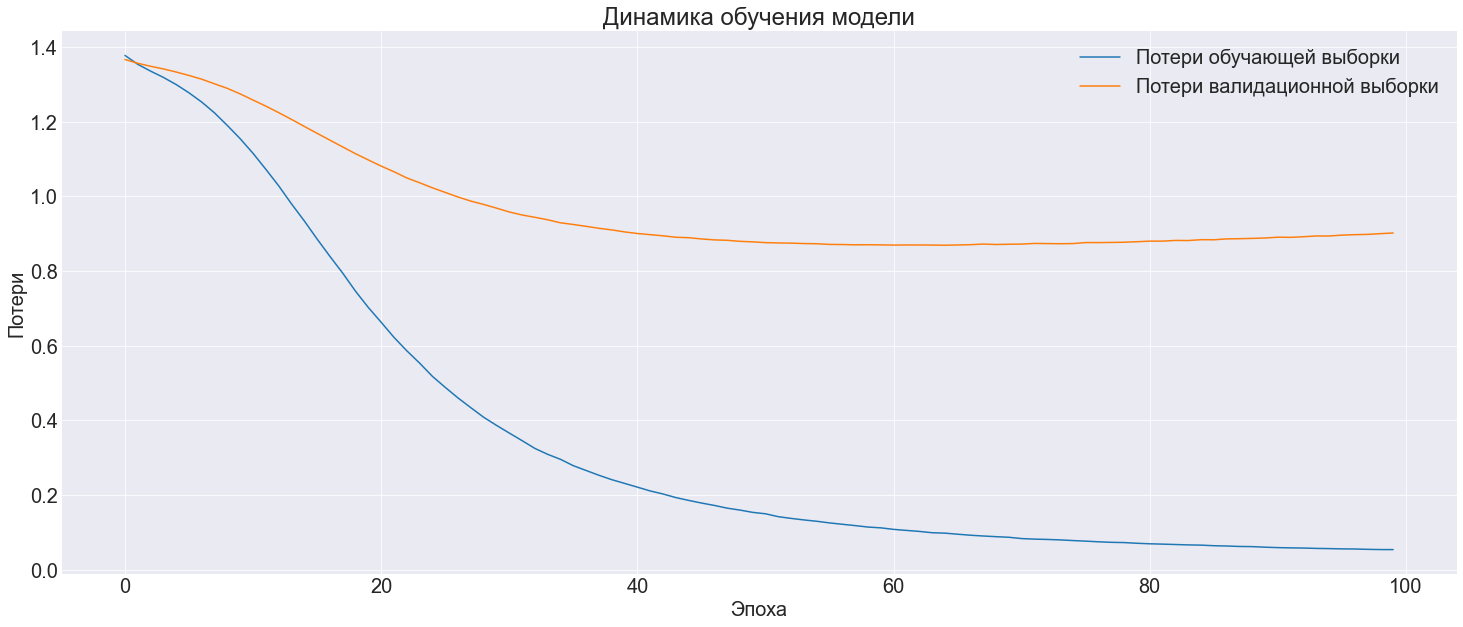

In [136]:
text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, EMBEDDING_SIZE, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=100)
draw_training_log(epochs, train_losses, val_losses)

In [137]:
trainer.evaluate(val_loader)

Потери: 0.9016286830107371, Точность: 0.6657283603096411


(0.9016286830107371, 0.6657283603096411)

Посмотрю, что будет, если изменить размер эмбеддинга, скорость обучения, а после остановлю тренировку на лучшем результате:

Эпоха 0, Тренировочные потери: 1.381, Валидационные потери: 1.375
Лучший результат: 1.375
Эпоха 1, Тренировочные потери: 1.366, Валидационные потери: 1.367
Лучший результат: 1.367
Эпоха 2, Тренировочные потери: 1.353, Валидационные потери: 1.361
Лучший результат: 1.361
Эпоха 3, Тренировочные потери: 1.341, Валидационные потери: 1.355
Лучший результат: 1.355
Эпоха 4, Тренировочные потери: 1.329, Валидационные потери: 1.350
Лучший результат: 1.350
Эпоха 5, Тренировочные потери: 1.317, Валидационные потери: 1.344
Лучший результат: 1.344
Эпоха 6, Тренировочные потери: 1.304, Валидационные потери: 1.339
Лучший результат: 1.339
Эпоха 7, Тренировочные потери: 1.288, Валидационные потери: 1.333
Лучший результат: 1.333
Эпоха 8, Тренировочные потери: 1.271, Валидационные потери: 1.327
Лучший результат: 1.327
Эпоха 9, Тренировочные потери: 1.253, Валидационные потери: 1.321
Лучший результат: 1.321
Эпоха 10, Тренировочные потери: 1.234, Валидационные потери: 1.313
Лучший результат: 1.313
Эпоха 11,

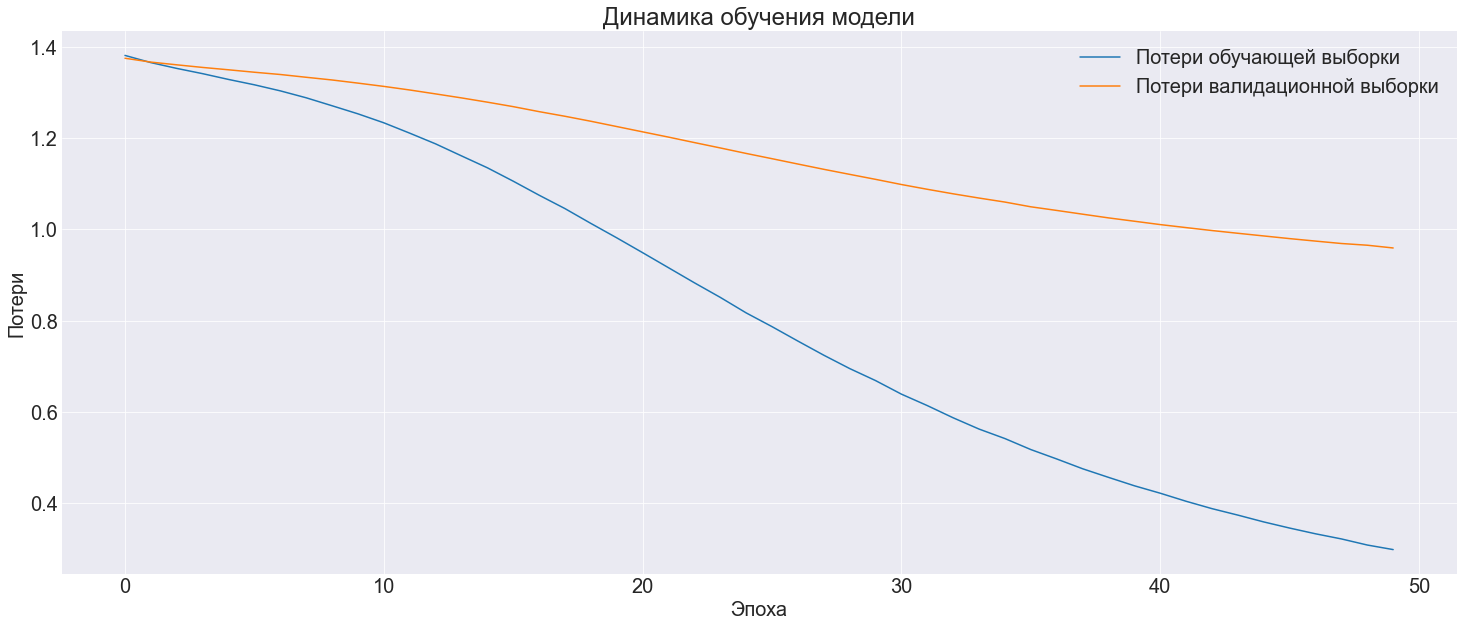

In [138]:
text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, 50, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=50)
draw_training_log(epochs, train_losses, val_losses)

In [139]:
trainer.evaluate(val_loader)

Потери: 0.959291065732638, Точность: 0.6439127375087966


(0.959291065732638, 0.6439127375087966)

С уменьшенными эмбеддингами точность упала. Попробую увеличить:

Эпоха 0, Тренировочные потери: 1.358, Валидационные потери: 1.348
Лучший результат: 1.348
Эпоха 1, Тренировочные потери: 1.311, Валидационные потери: 1.334
Лучший результат: 1.334
Эпоха 2, Тренировочные потери: 1.270, Валидационные потери: 1.318
Лучший результат: 1.318
Эпоха 3, Тренировочные потери: 1.225, Валидационные потери: 1.301
Лучший результат: 1.301
Эпоха 4, Тренировочные потери: 1.174, Валидационные потери: 1.278
Лучший результат: 1.278
Эпоха 5, Тренировочные потери: 1.115, Валидационные потери: 1.254
Лучший результат: 1.254
Эпоха 6, Тренировочные потери: 1.049, Валидационные потери: 1.227
Лучший результат: 1.227
Эпоха 7, Тренировочные потери: 0.978, Валидационные потери: 1.197
Лучший результат: 1.197
Эпоха 8, Тренировочные потери: 0.903, Валидационные потери: 1.167
Лучший результат: 1.167
Эпоха 9, Тренировочные потери: 0.827, Валидационные потери: 1.136
Лучший результат: 1.136
Эпоха 10, Тренировочные потери: 0.753, Валидационные потери: 1.109
Лучший результат: 1.109
Эпоха 11,

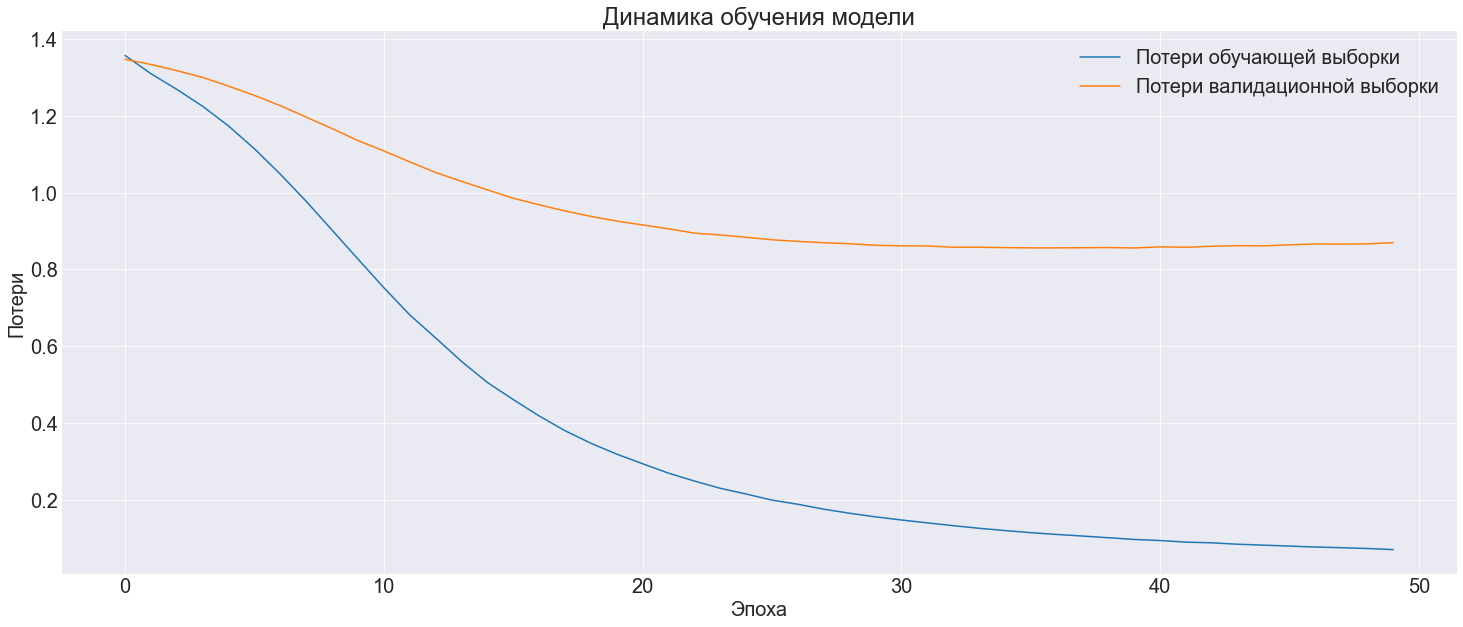

In [140]:
text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, 512, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=50)
draw_training_log(epochs, train_losses, val_losses)

Лучший результат улучшился, но модель склонна к переобучению. Попробую остановить её на 37 эпохе:

In [141]:
trainer.evaluate(val_loader)

Потери: 0.8697981337706248, Точность: 0.673469387755102


(0.8697981337706248, 0.673469387755102)

Почти первый результат после изменения архитектуры.

Эпоха 0, Тренировочные потери: 1.344, Валидационные потери: 1.337
Лучший результат: 1.337
Эпоха 1, Тренировочные потери: 1.274, Валидационные потери: 1.316
Лучший результат: 1.316
Эпоха 2, Тренировочные потери: 1.209, Валидационные потери: 1.287
Лучший результат: 1.287
Эпоха 3, Тренировочные потери: 1.137, Валидационные потери: 1.251
Лучший результат: 1.251
Эпоха 4, Тренировочные потери: 1.053, Валидационные потери: 1.218
Лучший результат: 1.218
Эпоха 5, Тренировочные потери: 0.964, Валидационные потери: 1.179
Лучший результат: 1.179
Эпоха 6, Тренировочные потери: 0.871, Валидационные потери: 1.140
Лучший результат: 1.140
Эпоха 7, Тренировочные потери: 0.779, Валидационные потери: 1.098
Лучший результат: 1.098
Эпоха 8, Тренировочные потери: 0.693, Валидационные потери: 1.066
Лучший результат: 1.066
Эпоха 9, Тренировочные потери: 0.610, Валидационные потери: 1.033
Лучший результат: 1.033
Эпоха 10, Тренировочные потери: 0.539, Валидационные потери: 1.006
Лучший результат: 1.006
Эпоха 11,

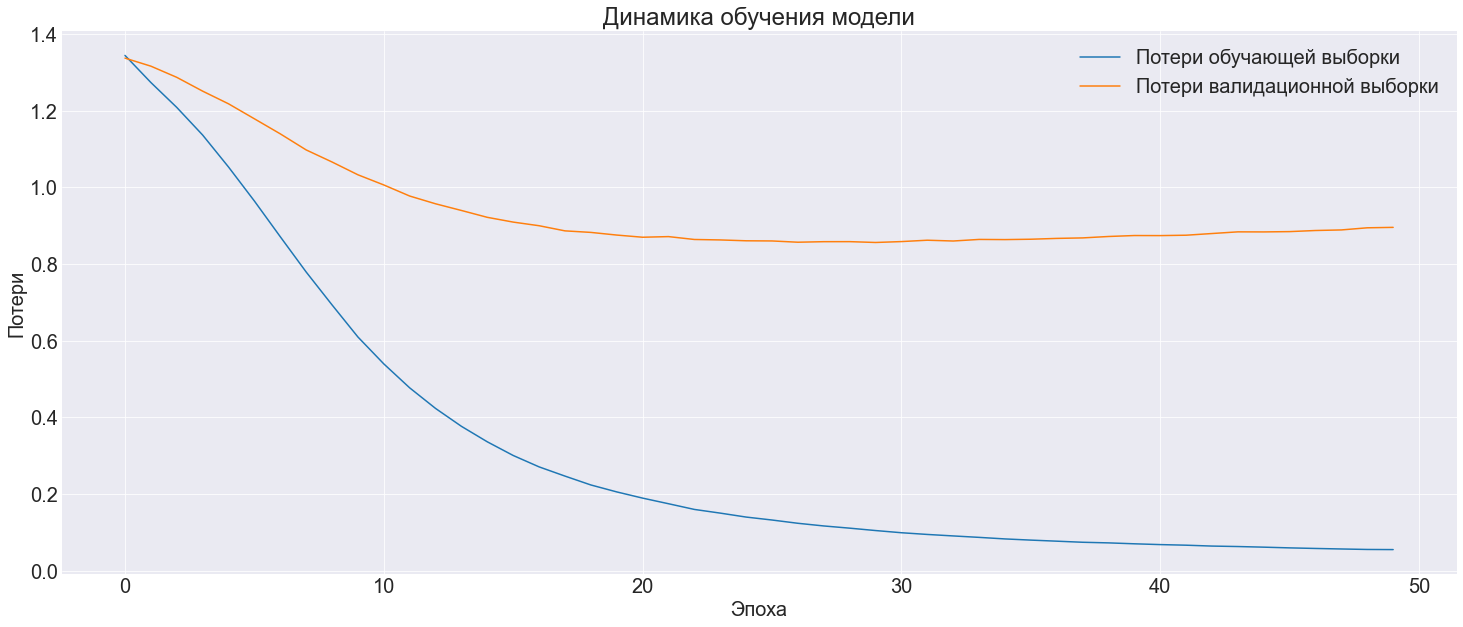

In [142]:
text_classifier = TextClassifier(VOCAB_SIZE, 1024, n_classes)
trainer = Trainer(text_classifier, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=50)
draw_training_log(epochs, train_losses, val_losses)

Эпоха 0, Тренировочные потери: 1.348, Валидационные потери: 1.335
Лучший результат: 1.335
Эпоха 1, Тренировочные потери: 1.274, Валидационные потери: 1.307
Лучший результат: 1.307
Эпоха 2, Тренировочные потери: 1.209, Валидационные потери: 1.276
Лучший результат: 1.276
Эпоха 3, Тренировочные потери: 1.139, Валидационные потери: 1.241
Лучший результат: 1.241
Эпоха 4, Тренировочные потери: 1.057, Валидационные потери: 1.207
Лучший результат: 1.207
Эпоха 5, Тренировочные потери: 0.967, Валидационные потери: 1.169
Лучший результат: 1.169
Эпоха 6, Тренировочные потери: 0.874, Валидационные потери: 1.130
Лучший результат: 1.130
Эпоха 7, Тренировочные потери: 0.783, Валидационные потери: 1.092
Лучший результат: 1.092
Эпоха 8, Тренировочные потери: 0.692, Валидационные потери: 1.060
Лучший результат: 1.060
Эпоха 9, Тренировочные потери: 0.613, Валидационные потери: 1.023
Лучший результат: 1.023
Эпоха 10, Тренировочные потери: 0.541, Валидационные потери: 0.997
Лучший результат: 0.997
Эпоха 11,

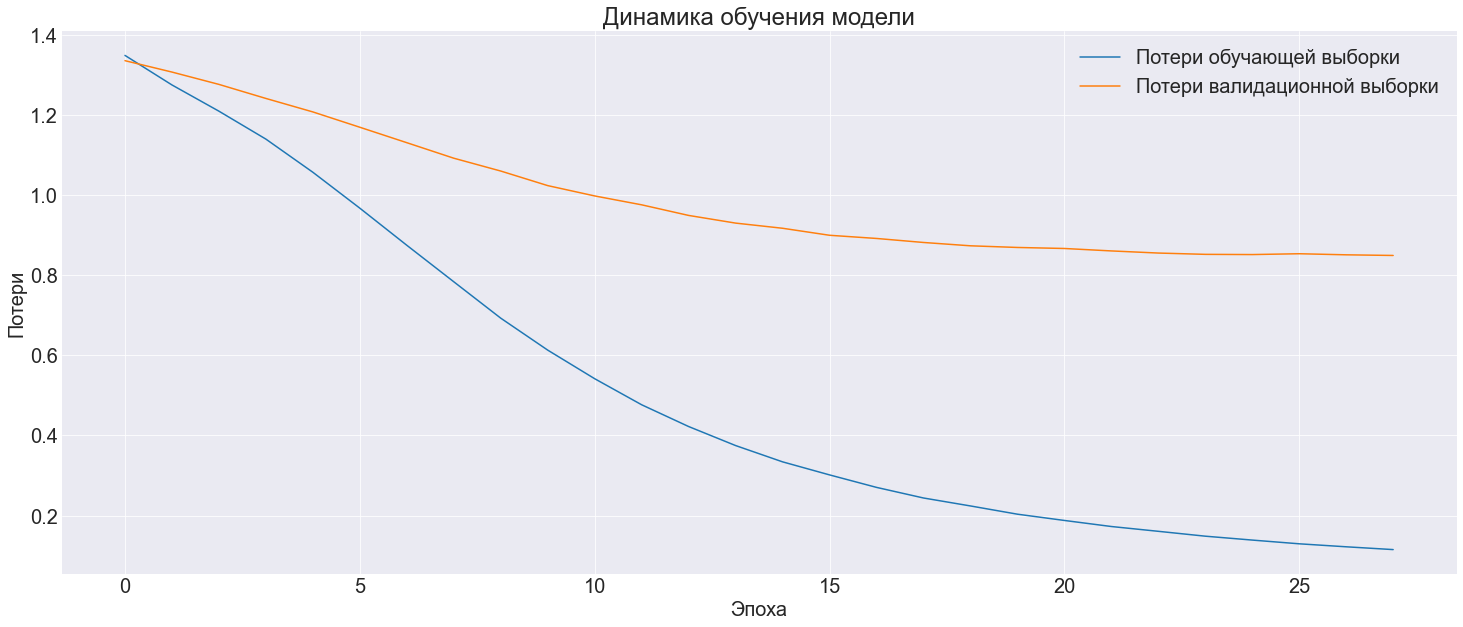

In [143]:
text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, 1024, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=28)
draw_training_log(epochs, train_losses, val_losses)

In [144]:
trainer.evaluate(val_loader)

Потери: 0.8489078978697459, Точность: 0.6790992258972555


(0.8489078978697459, 0.6790992258972555)

Пока что это лучший результат.

In [145]:
class Trainer(Trainer):
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=0.0005)
        self.criterion = nn.CrossEntropyLoss()
        self.lowest_val_loss = float('inf')
        self.prev_val_loss = float('inf')

Эпоха 0, Тренировочные потери: 1.363, Валидационные потери: 1.355
Лучший результат: 1.355
Эпоха 1, Тренировочные потери: 1.319, Валидационные потери: 1.342
Лучший результат: 1.342
Эпоха 2, Тренировочные потери: 1.285, Валидационные потери: 1.330
Лучший результат: 1.330
Эпоха 3, Тренировочные потери: 1.253, Валидационные потери: 1.316
Лучший результат: 1.316
Эпоха 4, Тренировочные потери: 1.220, Валидационные потери: 1.301
Лучший результат: 1.301
Эпоха 5, Тренировочные потери: 1.184, Валидационные потери: 1.285
Лучший результат: 1.285
Эпоха 6, Тренировочные потери: 1.145, Валидационные потери: 1.268
Лучший результат: 1.268
Эпоха 7, Тренировочные потери: 1.105, Валидационные потери: 1.250
Лучший результат: 1.250
Эпоха 8, Тренировочные потери: 1.059, Валидационные потери: 1.231
Лучший результат: 1.231
Эпоха 9, Тренировочные потери: 1.013, Валидационные потери: 1.212
Лучший результат: 1.212
Эпоха 10, Тренировочные потери: 0.966, Валидационные потери: 1.192
Лучший результат: 1.192
Эпоха 11,

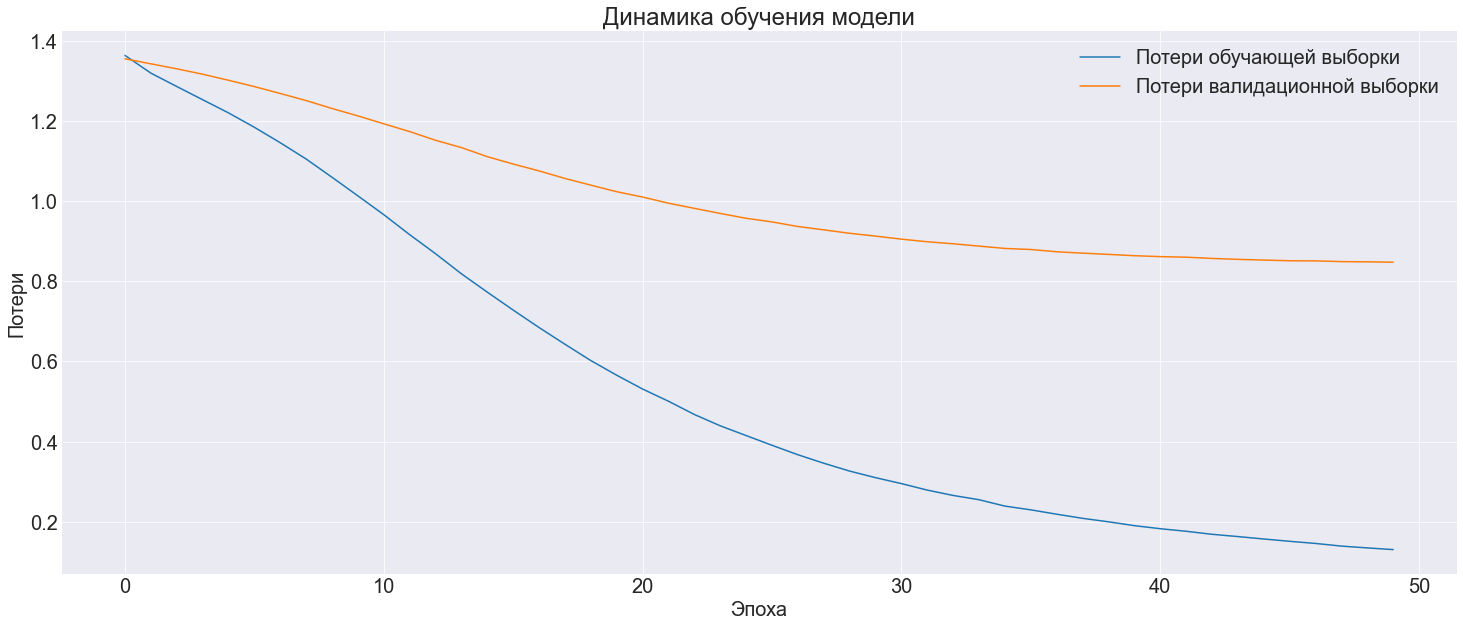

In [146]:
text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, 1024, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=50)
draw_training_log(epochs, train_losses, val_losses)

In [148]:
trainer.evaluate(val_loader)

Потери: 0.8472041835387548, Точность: 0.6833216045038705


(0.8472041835387548, 0.6833216045038705)

Точность стала чуть лучше. 
Напоследок хочу попробовать изменить архитекутуру более масштабно и проверить на том же размере эмбеддинга, получиться ли улучшить результат на таких чувствительных данных.

In [149]:
class Trainer(Trainer):
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.lowest_val_loss = float('inf')
        self.prev_val_loss = float('inf')

In [150]:
class TextClassifier_v3(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_classes, drop=0.5):
        super(TextClassifier_v3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.linear_hidden_1 = nn.Linear(embedding_size, 256)
        self.linear = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(drop)
    
    def forward(self, X_batch):
        X = self.embedding(X_batch)
        X = X.permute(0, 2, 1)
        X = F.avg_pool1d(X, kernel_size=X.shape[2]).squeeze(2)
        
        X = F.relu(self.linear_hidden_1(X))
        X = self.dropout(X)
        X = self.linear(X)
        
        return X

Эпоха 0, Тренировочные потери: 1.349, Валидационные потери: 1.336
Лучший результат: 1.336
Эпоха 1, Тренировочные потери: 1.287, Валидационные потери: 1.302
Лучший результат: 1.302
Эпоха 2, Тренировочные потери: 1.191, Валидационные потери: 1.254
Лучший результат: 1.254
Эпоха 3, Тренировочные потери: 1.064, Валидационные потери: 1.182
Лучший результат: 1.182
Эпоха 4, Тренировочные потери: 0.904, Валидационные потери: 1.106
Лучший результат: 1.106
Эпоха 5, Тренировочные потери: 0.727, Валидационные потери: 1.031
Лучший результат: 1.031
Эпоха 6, Тренировочные потери: 0.580, Валидационные потери: 0.983
Лучший результат: 0.983
Эпоха 7, Тренировочные потери: 0.459, Валидационные потери: 0.940
Лучший результат: 0.940
Эпоха 8, Тренировочные потери: 0.364, Валидационные потери: 0.902
Лучший результат: 0.902
Эпоха 9, Тренировочные потери: 0.296, Валидационные потери: 0.884
Лучший результат: 0.884
Эпоха 10, Тренировочные потери: 0.239, Валидационные потери: 0.872
Лучший результат: 0.872
Эпоха 11,

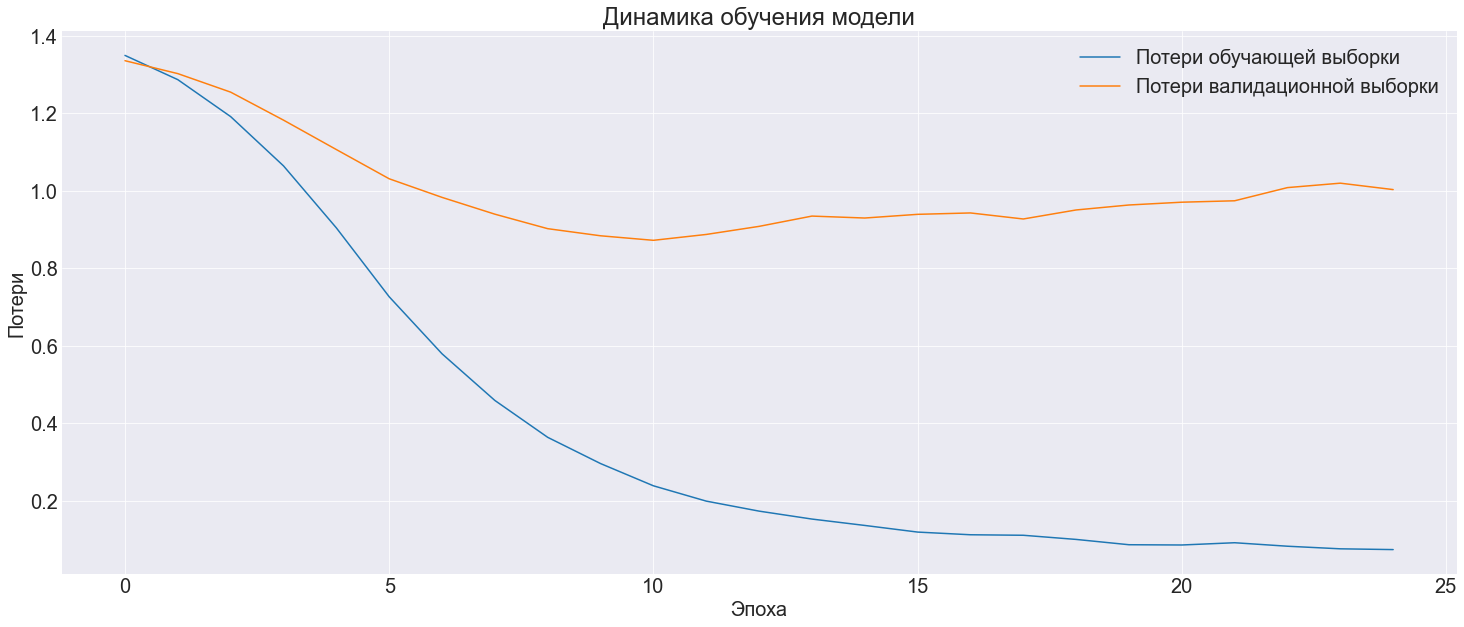

In [151]:
text_classifier_v3 = TextClassifier_v3(VOCAB_SIZE, 1024, n_classes, drop=0.7)
trainer = Trainer(text_classifier_v3, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=25)
draw_training_log(epochs, train_losses, val_losses)

In [152]:
trainer.evaluate(val_loader)

Потери: 1.0031099170446396, Точность: 0.6798029556650246


(1.0031099170446396, 0.6798029556650246)

И всё же, данной модели дополнительные слои не нужны, они лишь ухудшают результат.  
В итоге конечный результат следующий. Лучший результат получился у следующей конфигурации:

Эпоха 0, Тренировочные потери: 1.364, Валидационные потери: 1.348
Лучший результат: 1.348
Эпоха 1, Тренировочные потери: 1.318, Валидационные потери: 1.339
Лучший результат: 1.339
Эпоха 2, Тренировочные потери: 1.287, Валидационные потери: 1.326
Лучший результат: 1.326
Эпоха 3, Тренировочные потери: 1.254, Валидационные потери: 1.311
Лучший результат: 1.311
Эпоха 4, Тренировочные потери: 1.220, Валидационные потери: 1.297
Лучший результат: 1.297
Эпоха 5, Тренировочные потери: 1.185, Валидационные потери: 1.282
Лучший результат: 1.282
Эпоха 6, Тренировочные потери: 1.146, Валидационные потери: 1.265
Лучший результат: 1.265
Эпоха 7, Тренировочные потери: 1.105, Валидационные потери: 1.247
Лучший результат: 1.247
Эпоха 8, Тренировочные потери: 1.060, Валидационные потери: 1.229
Лучший результат: 1.229
Эпоха 9, Тренировочные потери: 1.015, Валидационные потери: 1.210
Лучший результат: 1.210
Эпоха 10, Тренировочные потери: 0.968, Валидационные потери: 1.192
Лучший результат: 1.192
Эпоха 11,

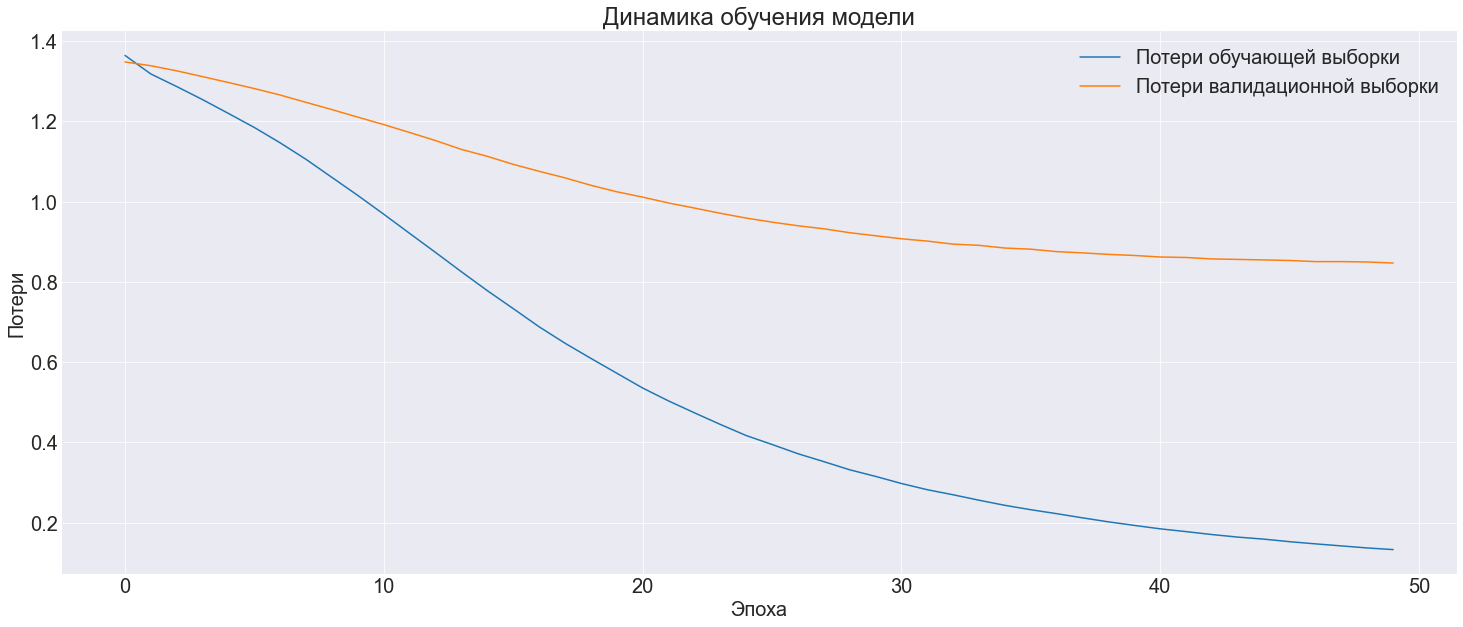

In [153]:
class Trainer(Trainer):
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=0.0005)
        self.criterion = nn.CrossEntropyLoss()
        self.lowest_val_loss = float('inf')
        self.prev_val_loss = float('inf')


text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, 1024, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=50)
draw_training_log(epochs, train_losses, val_losses)

Эпоха 0, Тренировочные потери: 1.344, Валидационные потери: 1.336
Лучший результат: 1.336
Эпоха 1, Тренировочные потери: 1.270, Валидационные потери: 1.309
Лучший результат: 1.309
Эпоха 2, Тренировочные потери: 1.204, Валидационные потери: 1.279
Лучший результат: 1.279
Эпоха 3, Тренировочные потери: 1.131, Валидационные потери: 1.247
Лучший результат: 1.247
Эпоха 4, Тренировочные потери: 1.048, Валидационные потери: 1.208
Лучший результат: 1.208
Эпоха 5, Тренировочные потери: 0.957, Валидационные потери: 1.169
Лучший результат: 1.169
Эпоха 6, Тренировочные потери: 0.863, Валидационные потери: 1.131
Лучший результат: 1.131
Эпоха 7, Тренировочные потери: 0.771, Валидационные потери: 1.092
Лучший результат: 1.092
Эпоха 8, Тренировочные потери: 0.683, Валидационные потери: 1.055
Лучший результат: 1.055
Эпоха 9, Тренировочные потери: 0.604, Валидационные потери: 1.026
Лучший результат: 1.026
Эпоха 10, Тренировочные потери: 0.533, Валидационные потери: 0.994
Лучший результат: 0.994
Эпоха 11,

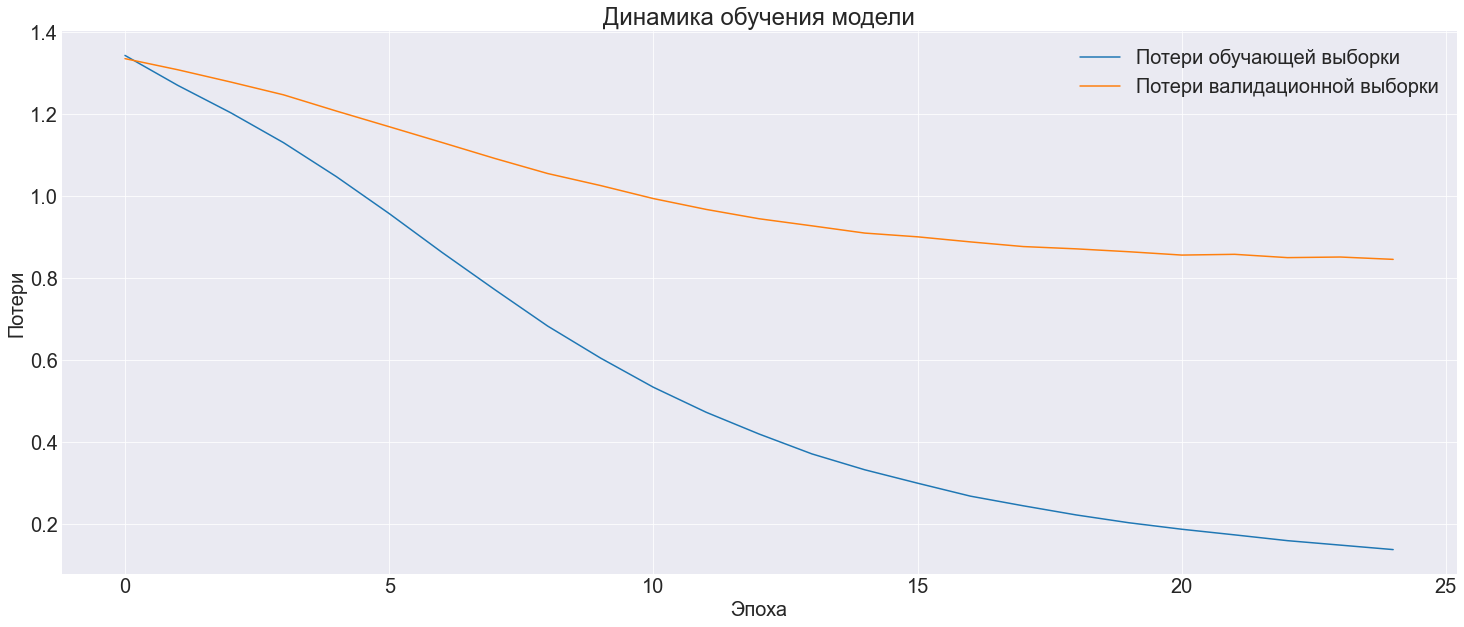

In [171]:
text_classifier_v2 = TextClassifier_v2(VOCAB_SIZE, 1024, n_classes)
trainer = Trainer(text_classifier_v2, device)
epochs, train_losses, val_losses = trainer.train(train_data=train_loader, val_data=val_loader, n_epochs=25)
draw_training_log(epochs, train_losses, val_losses)

In [154]:
trainer.evaluate(val_loader)

Потери: 0.8468425770600637, Точность: 0.6805066854327938


(0.8468425770600637, 0.6805066854327938)

Можно объединить тестовую и валидационную выборки и проверять модель на тестовых данных.

In [81]:
normalized_df_full_train = normalize(df_full_train)
norm_filt_df_full_train = filter_sentence_lengths(normalized_df_full_train, 0.1, 0.1)
full_train_sentences = norm_filt_df_full_train["text"].values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5681/5681 [06:02<00:00, 15.68it/s]


In [155]:
NORM_FULL_TRAIN_NAME = "normalized_df_full_train.pkl"

In [84]:
save_data(normalized_df_full_train, NORM_FULL_TRAIN_NAME)

___

In [156]:
normalized_df_full_train = load_data(NORM_FULL_TRAIN_NAME)
norm_filt_df_full_train = filter_sentence_lengths(normalized_df_full_train, 0.1, 0.1)
full_train_sentences = norm_filt_df_full_train["text"].values

___

Количество предложений: 4545
Среднее значение: 20.41
Стандартное отклонение: 6.27
Количество уникальных слов: 8866


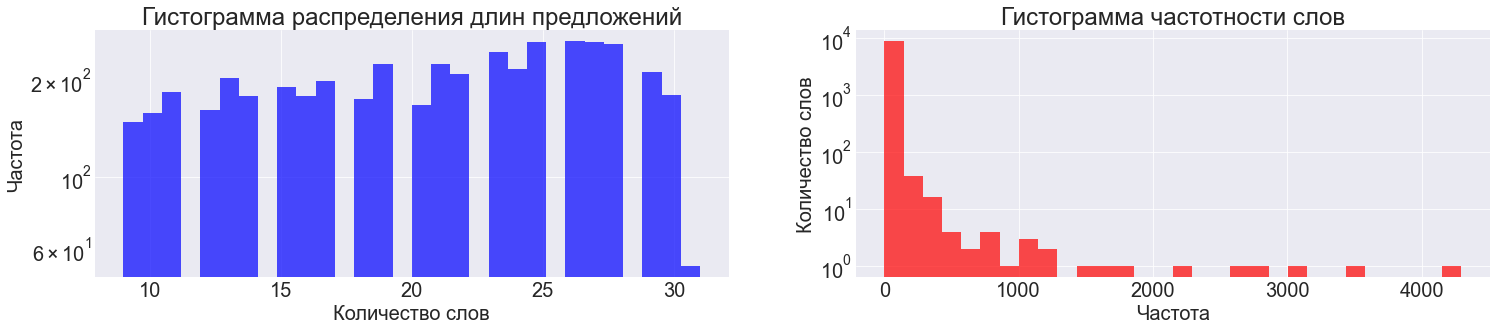

In [157]:
show_statistics(norm_filt_df_full_train)

In [158]:
VOCAB_FULL_SIZE = 8860
vocab_full = Vocabulary(full_train_sentences, VOCAB_FULL_SIZE)

In [159]:
full_train_tensors = [torch.tensor(vocab_full.tokenize(sent), dtype=torch.long) for sent in full_train_sentences]
y_full_train = encoder.fit_transform(norm_filt_df_full_train["emotion"].values)
full_train_emotions = torch.LongTensor(y_full_train)
full_train_dataset = EmotionDataset(full_train_tensors, full_train_emotions)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

Очищенный от валидации на эпохах и с классом предсказания эмоции предложения класс тренировки:

In [160]:
class Trainer():
    def __init__(self, model, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=0.0005)
        self.criterion = nn.CrossEntropyLoss()
    
    def train(self, data, epochs):
        losses = {}
        
        for epoch in range(epochs):
            for texts, labels in data:
                texts, labels = texts.to(self.device), labels.to(self.device)
                outputs = self.model(texts)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            loss = loss.item()
            losses[epoch] = loss
            print(f'Эпоха {epoch}, Потери: {loss}')

        return losses

    def evaluate(self, data):
        self.model.eval()
        losses = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for texts, labels in data:
                texts, labels = texts.to(self.device), labels.to(self.device)
                outputs = self.model(texts)
                loss = self.criterion(outputs, labels)
                losses += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Потери: {losses / len(data)}, Точность: {accuracy}')
    
        return losses / len(data), accuracy

    def predict(self, text, vocab):
        self.model.eval()
        tokens = vocab.tokenize(text)
        text_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.model(text_tensor)
            prediction = torch.argmax(output, dim=1)
            
        return prediction.item()

In [161]:
text_classifier_v2 = TextClassifier_v2(VOCAB_FULL_SIZE, 1024, n_classes)
trainer = Trainer(text_classifier_v2, device)
losses = trainer.train(full_train_loader, epochs=50)

Эпоха 0, Потери: 1.3332031965255737
Эпоха 1, Потери: 1.2913007736206055
Эпоха 2, Потери: 1.247304081916809
Эпоха 3, Потери: 1.199607253074646
Эпоха 4, Потери: 1.1471608877182007
Эпоха 5, Потери: 1.089729905128479
Эпоха 6, Потери: 1.0278794765472412
Эпоха 7, Потери: 0.9627127051353455
Эпоха 8, Потери: 0.8956432938575745
Эпоха 9, Потери: 0.8281861543655396
Эпоха 10, Потери: 0.7617710828781128
Эпоха 11, Потери: 0.6976145505905151
Эпоха 12, Потери: 0.6366490125656128
Эпоха 13, Потери: 0.5795099139213562
Эпоха 14, Потери: 0.5265614986419678
Эпоха 15, Потери: 0.47794148325920105
Эпоха 16, Потери: 0.4336165487766266
Эпоха 17, Потери: 0.3934316635131836
Эпоха 18, Потери: 0.35715511441230774
Эпоха 19, Потери: 0.32451146841049194
Эпоха 20, Потери: 0.2952066659927368
Эпоха 21, Потери: 0.26894405484199524
Эпоха 22, Потери: 0.24543572962284088
Эпоха 23, Потери: 0.22440797090530396
Эпоха 24, Потери: 0.2056049406528473
Эпоха 25, Потери: 0.18879055976867676
Эпоха 26, Потери: 0.17374874651432037
Эпоха 

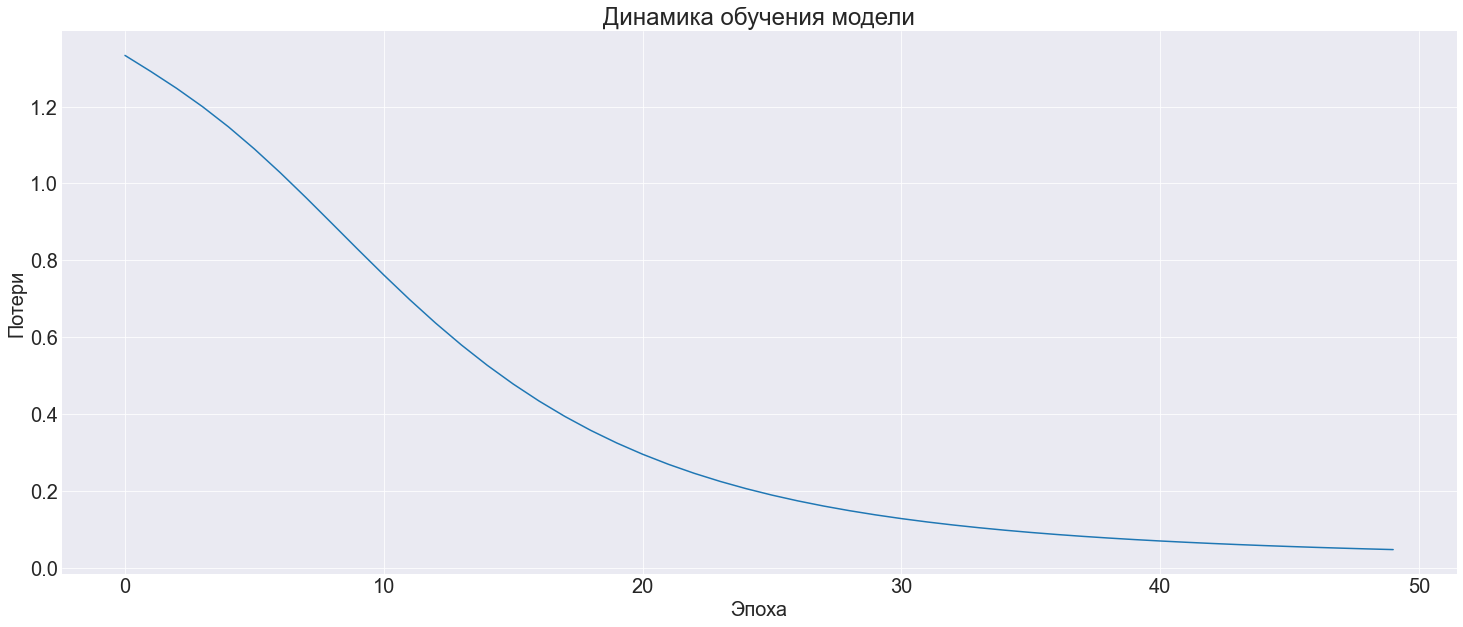

In [162]:
plt.figure(figsize=(25, 10))
plt.rc("font", size=20)

losses_df = pd.DataFrame(losses.items())
plt.plot(losses_df.iloc[:,0], losses_df.iloc[:,1])
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Динамика обучения модели")
None

Теперь нужно проверить окончательную модель на тестовых данных:

In [96]:
normalized_df_test = normalize(df_test)
norm_filt_df_test = filter_sentence_lengths(normalized_df_test, 0.1, 0.1)
test_sentences = norm_filt_df_test["text"].values
test_tensors = [torch.tensor(vocab_full.tokenize(sent), dtype=torch.long) for sent in test_sentences]
y_test = encoder.fit_transform(norm_filt_df_test["emotion"].values)
test_emotions = torch.LongTensor(y_test)
test_dataset = EmotionDataset(test_tensors, test_emotions)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1421/1421 [01:34<00:00, 14.97it/s]


In [163]:
TEST_DATALOADER_NAME = "test_dataloader.pkl"

In [98]:
save_data(test_loader, TEST_DATALOADER_NAME)

In [164]:
test_loader = load_data(TEST_DATALOADER_NAME)

In [165]:
trainer.evaluate(test_loader)

Потери: 0.9899570014741685, Точность: 0.6534740545294635


(0.9899570014741685, 0.6534740545294635)

Итоговая точность составила 0.653.

___